©Claudio Sartori - Classification

# Classification with hyperparameter tuning

### Aim: Show classification with different strategies for the tuning and evaluation of the classifier
1. simple __holdout__
1. __holdout with validation__ train and validate repeatedly changing a hyperparameter, to find the value giving the best score, then test for the final score
1. __cross validation__ on training set, then score on test set
1. __bagging__ it is an _ensemble_ method made available in `scikit-learn`

__NB__: You should not interpret those experiments as a way to find the _best_ evaluation method, but simply as examples of _how_ to do the evaluation. 

If you look at the final report, methods __1__ to __3__ are meant for increasing evaluation reliability, method __3__ is the more reliable, but it requires several repetitions for cross validation, therefore, if the learning method is expensive, it requires long processing time. If, due to intrinsic variation caused by random sampling, it turns out that methods __1__ or __2__ give higher accuracy, this means simply that the forecast towards generalisation is less reliable.

Method __4__ is on a different dimension, it simply shows that a good result can be obtained with an _ensemble_ of simpler classifiers (the best value for the hyperparameter `max_depth` is smaller than in the other cases)
    

### Workflow
- download the data
- drop the useless data
- separe the predicting attributes X from the class attribute y
- split X and y into training and test

- part 1 - single run with default parameters
    - initialise an estimator with the chosen model generator
    - fit the estimator with the training part of X
    - show the tree structure
    - part 1.1 
        - predict the y values with the fitted estimator and the train data
            - compare the predicted values with the true ones and compute the accuracy on the training set 
    - part 1.2
        - predict the y values with the fitted estimator and the test data
            - compare the predicted values with the true ones and compute the accuracy on the test set 

- part 2 - multiple runs changing a parameter
    - prepare the structure to hold the accuracy data for the multiple runs
    - repeat for all the values of the parameter
        - initialise an estimator with the current parameter value
        - fit the estimator with the training part
        - predict the class for the test part
        - compute the accuracy and store the value
    - find the parameter value for the top accuracy

- part 3 - compute accuracy with cross validation
    - prepare the structure to hold the accuracy data for the multiple runs
    - repeat for all the values of the parameter
        - initialise an estimator with the current parameter value
        - compute the accuracy with cross validation and store the value
    - find the parameter value for the top accuracy
    - fit the estimator with the entire X
    - show the resulting tree and classification report

The data are already in your folder, use the name `winequality-red.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
random_state = 15
np.random.seed(random_state)
# the random state is reset here in numpy, all the scikit-learn procedure use the numpy random state
# obviously the experiment can be repeated exactly only with a complete run of the program

#data_url = "uci_breast_tissue_data/BreastTissue.csv"
data_url = "winequality-red.csv"
target_name = 'quality'
to_drop = []
# parameter_values to be determined after the fitting of the full tree
df = pd.read_csv(data_url , sep = ';')
print("Shape of the input data {}".format(df.shape))

Shape of the input data (1599, 12)


Have a quick look to the data.
- use the .shape attribute to see the size
- use the `.head()` function to see column names and some data
- use the `.hist()` method for an histogram of the columns
- use the .unique method to see the class values

In [2]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Use the `hist` method of the DataFrame to show the histograms of the attributes

NB: a semicolon at the end of a statement suppresses the `Out[]`

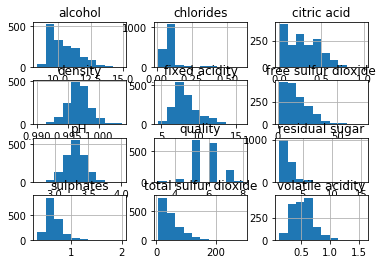

In [3]:
df.hist();

Print the unique class labels (hint: use the `unique` method of pandas Series

In [4]:
classes = df[target_name].unique()
classes.sort()
print(classes)

[3 4 5 6 7 8]


#### Split the data into the predicting values X and the class y
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [5]:
X = df.drop([target_name], axis = 1) # drop the class column
y = df[target_name] # Class only

Another quick look to data

In [6]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [7]:
y.head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

## Prepare a simple model selection: holdout method
- Split X and y in train and test
- Show the number of samples in train and test, show the number of features

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state) # default Train 0.75- Test 0.25
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 1199 samples in the training dataset
There are 400 samples in the testing dataset
Each sample has 11 features


## Part 1

- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(criterion="entropy")`
- Fit the estimator on the train data and target

In [9]:
estimator = tree.DecisionTreeClassifier(criterion="entropy")
estimator.fit(X_train, y_train);

Look at the tree structure
- the feature names are used to show the tests in the nodes
    - they are the column names in the X
- the class names 
    - the attribute `estimator.classes_` contains the array of classes detected in the target; if the classes are numbers they have to be transformed in strings with `str()`
- the dept of the visualization can be limited with the parameter `max_depth` 
    
`plt.figure(figsize = (20,20))
 tree.plot_tree(estimator
          , filled=True
          , feature_names = X.columns
          , class_names = str(estimator.classes_)
          , rounded = True
          , proportion = True
          , max_depth = 1
              );`

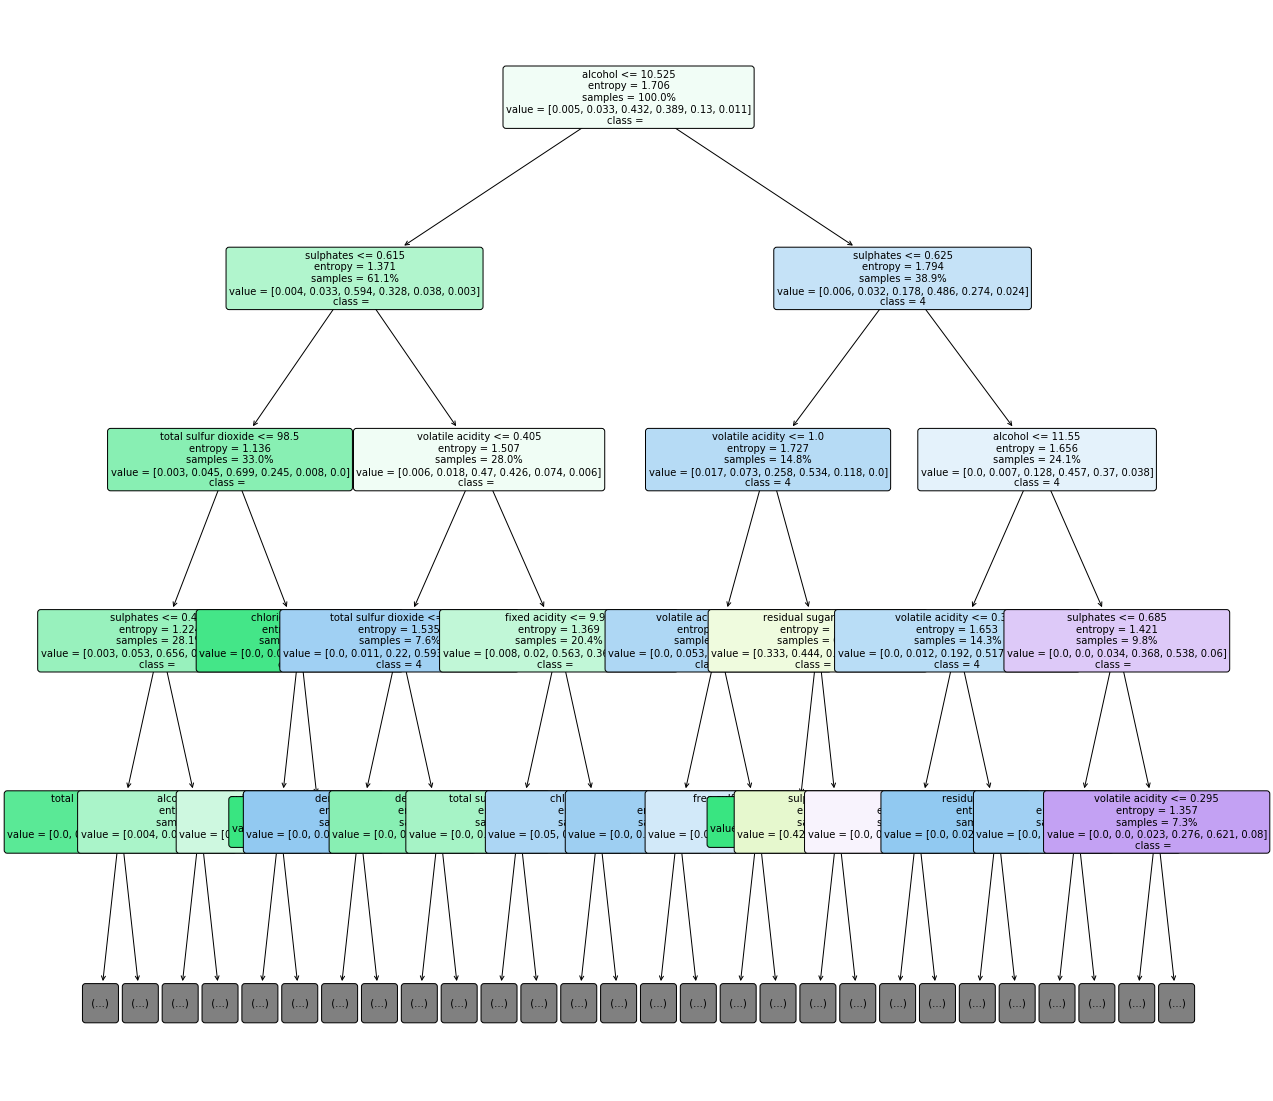

In [10]:
plt.figure(figsize = (20,20), 
#           dpi = 500, # this increments the detail, to do a more detiled inspection
          )
tree.plot_tree(estimator
          , filled=True
          , feature_names = X.columns
          , class_names = str(estimator.classes_)
          , rounded = True
          , proportion = True
          , fontsize = 10
          , max_depth = 4 # limited view, since the full tree is very complex
              );

### Part 1.1

Let's see how it works on training data
- predict the target using the fitted estimator on the training data
- compute the accuracy on the training set using `accuracy_score(<target>,<predicted_target) * 100`

In [11]:
y_predicted_train = estimator.predict(X_train)
accuracy_train = accuracy_score(y_predicted_train, y_train)*100
print("The accuracy on training set is {0:.1f}%".format(accuracy_train))

The accuracy on training set is 100.0%


### Part 1.2

That's more significant: how it works on test data
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [12]:
y_predicted_test = estimator.predict(X_test)
accuracy_ho = accuracy_score(y_test, y_predicted_test) * 100
fitted_max_depth = estimator.tree_.max_depth
print("The accuracy on test set is {0:.1f}%".format(accuracy_ho))
print("The maximum depth of the fitted tree is {}".format(fitted_max_depth))
parameter_values = range(1,fitted_max_depth+1)

The accuracy on test set is 58.8%
The maximum depth of the fitted tree is 16


## Part 2

Optimising the tree: limit the maximum tree depth. We will use the three way splitting: `train, validation, test`. For simplicity, since we already splitted in _train_ and _test_, we will furtherly split the _train_
- split the training set into two parts: __train_t__ and __val__
- max_depth - pruning the tree cutting the branches which exceed max_depth
- the experiment is repeated varying the parameter from 1 to the depth of the unpruned tree
- the scores for the various values are collected and plotted

In [13]:
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train
                                                      , y_train
                                                      , random_state = random_state) # default Train 0.75- Test 0.25
print("There are {} samples in the training dataset".format(X_train_t.shape[0]))
print("There are {} samples in the validation dataset".format(X_val.shape[0]))

There are 899 samples in the training dataset
There are 300 samples in the validation dataset


### Loop for computing the score varying the hyperparameter
- initialise a list to contain the scores
- loop varying `par` in `parameter_values`
    - initialize an estimator with a DecisionTreeClassifier, using `par` as maximum depth and `entropy` as criterion
    - fit the estimator on the `train_t` part of the features and the target 
    - predict with the estimator using the validation features
    - compute the score comparing the prediction with the validation target and append it to the end of the list

In [14]:
scores = []
# all_scores = []
# parameter_values = [10**exp for exp in np.arange(-2.0,0.0, 0.25)]
#parameter_values = np.arange(0,1, 0.05)
for par in parameter_values:
    estimator = tree.DecisionTreeClassifier(criterion="entropy"
                                            , max_depth = par
                                           )
    estimator.fit(X_train_t, y_train_t)
    y_predicted_val = estimator.predict(X_val)
    score =  accuracy_score(y_val, y_predicted_val) * 100 # compute the matches between prediction and true classes
    scores.append(score)

### Plot the results
Plot using the `parameter_values` and the list of `scores`

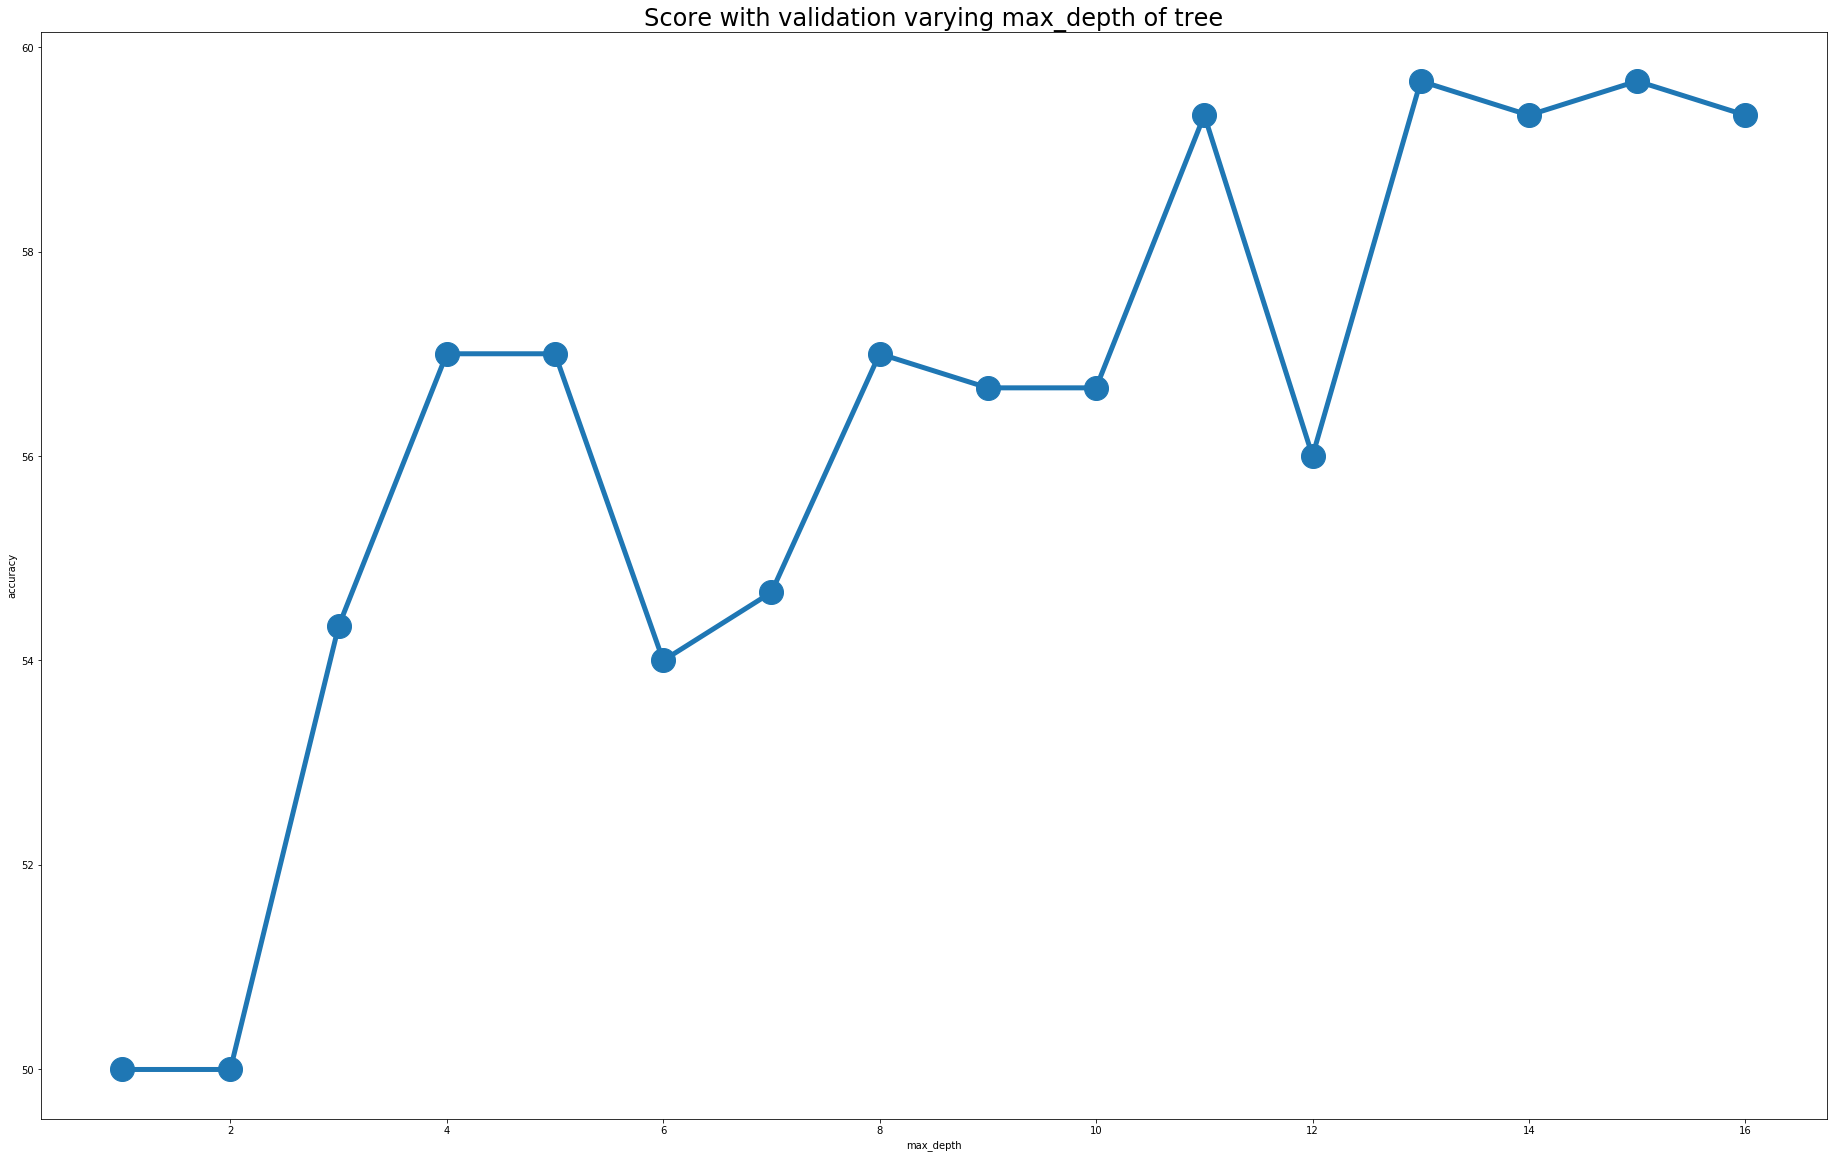

In [15]:
plt.figure(figsize=(32,20))
plt.plot(parameter_values, scores, '-o', linewidth=5, markersize=24)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Score with validation varying max_depth of tree", fontsize = 24)
plt.show();

### Fit the tree after validation and print summary
- store the parameter value giving the best score with `np.argmax(scores)`
- initialize an estimator as a DecisionTreeClassifier, using the best parameter value computed above as maximum depth and `entropy` as criterion
- fit the estimator using the `train` part
- use the fitted estimator to predict using the test features
- compute the accuracy on the test and store it on a variable for the final summary
- print the accuracy on the test set and the best parameter value

In [16]:
top_par_hov = parameter_values[np.argmax(scores)]
estimator = tree.DecisionTreeClassifier(criterion="entropy", max_depth = top_par_hov)
estimator.fit(X_train, y_train)
y_predicted_test = estimator.predict(X_test)
accuracy_hov = accuracy_score(y_predicted_test, y_test) * 100
print("The top accuracy is {0:.1f}%".format(accuracy_hov))
print("Obtained with max_depth = {}".format(top_par_hov))

The top accuracy is 56.0%
Obtained with max_depth = 13


## Part 3 - Tuning with __Cross Validation__
Optimisation of the hyperparameter with __cross validation__ (cv suffix in the variable names).
Now we will tune the hyperparameter looping on cross validation with the __training set__, then we will fit the estimator on the training set and evaluate the performance on the __test set__

- initialize an empty list for the scores
- loop varying `par` in `parameter_values`
    - initialize an estimator with a DecisionTreeClassifier, using `par` as maximum depth and `entropy` as criterion
    - compute the score using the estimator on the `train` part of the features and the target using 
        - `cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv = 5)`
        - the result is list of scores
    - compute the average of the scores and append it to the end of the list
- print the scores

In [17]:
avg_scores = []
for par in parameter_values:
    estimator = tree.DecisionTreeClassifier(criterion="entropy"
                                            , max_depth = par
                                            )
    scores = cross_val_score(estimator, X_train, y_train
                             , scoring='accuracy', cv = 5)
    # cross_val_score produces an array with one score for each fold
    avg_scores.append(np.mean(scores))
print(avg_scores)

[0.5519152314979172, 0.5435525832020326, 0.5713089389088722, 0.5678437532607689, 0.5577529689800829, 0.5328357011331578, 0.5434774526459061, 0.5443793438898566, 0.5585019217156184, 0.5559627582243493, 0.5636209817495066, 0.5643876543587679, 0.5693922353804821, 0.5667868463793229, 0.571864056684633, 0.566054670861477]


Plot using the `parameter_values` and the list of `scores`

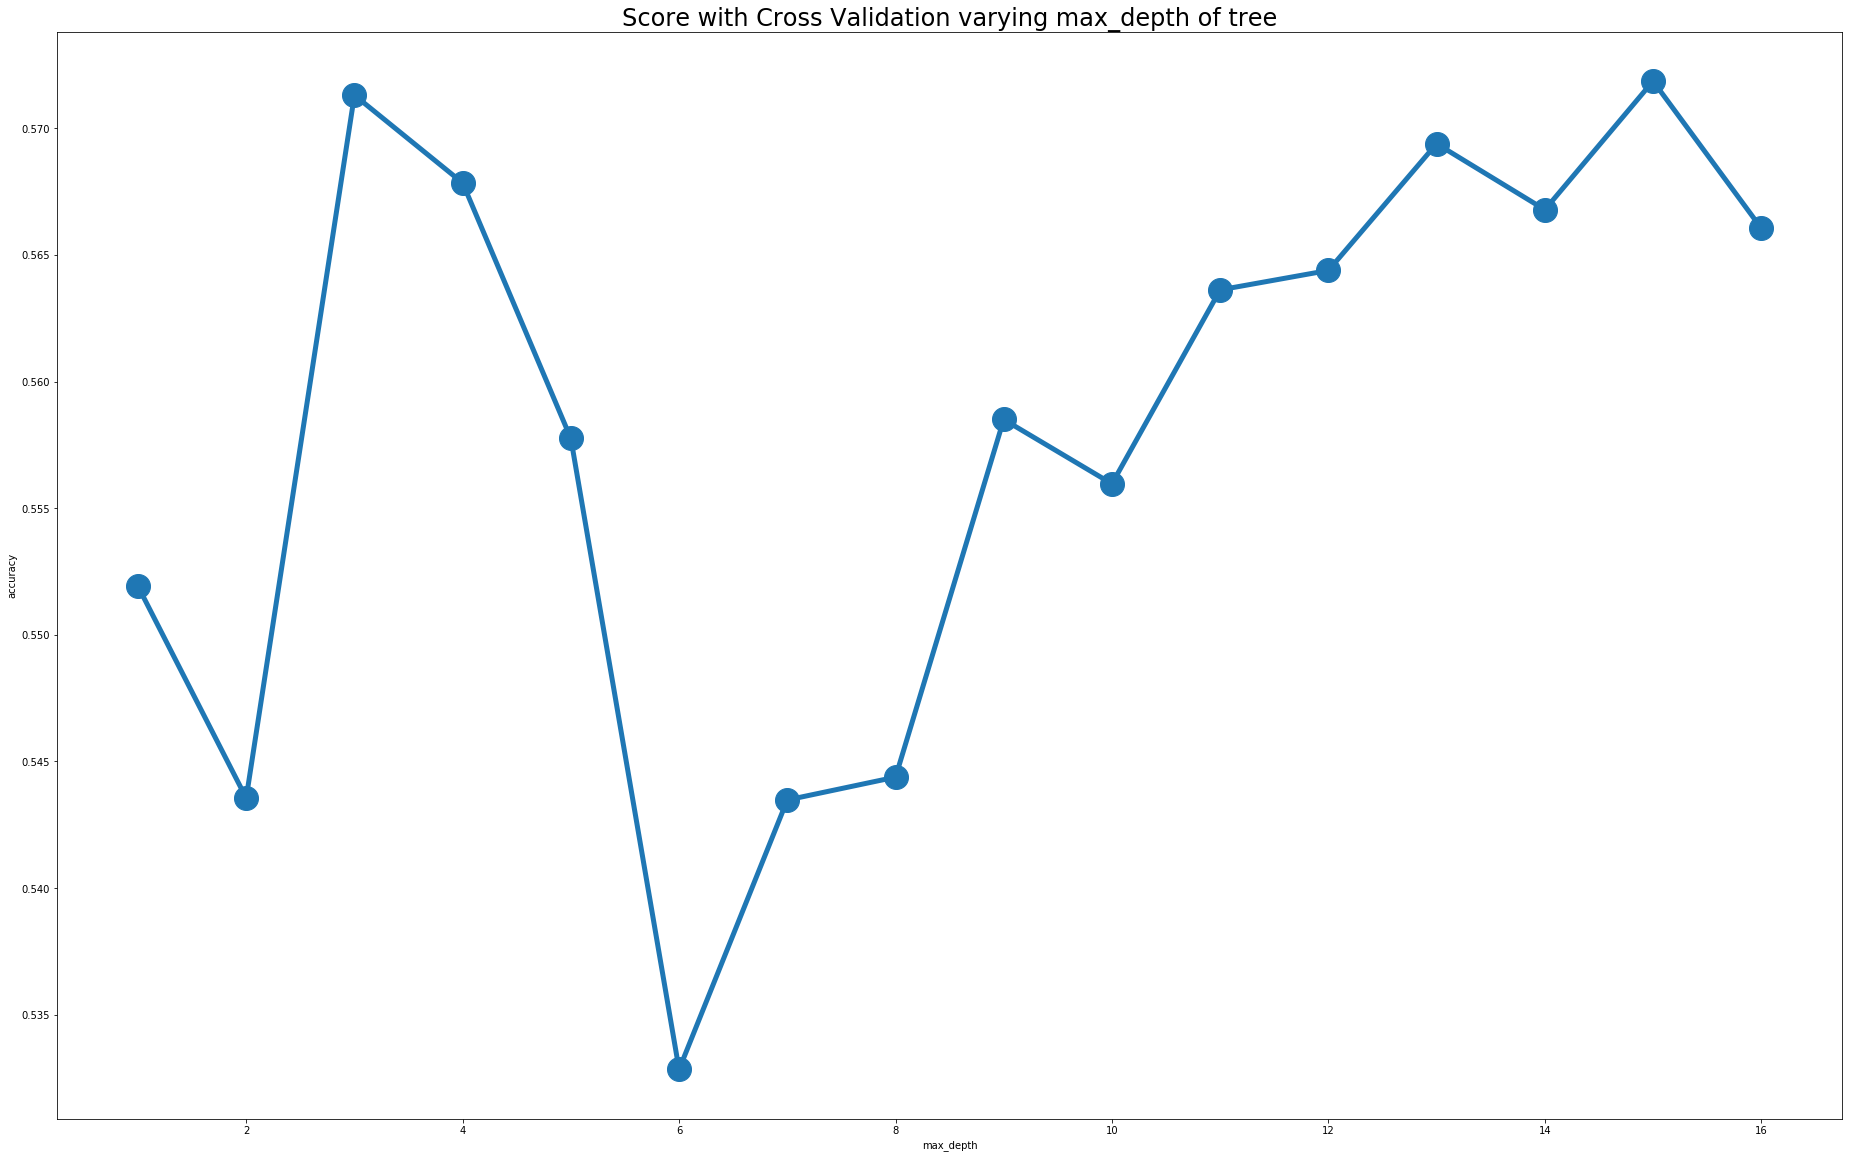

In [18]:
plt.figure(figsize=(32,20))
plt.plot(parameter_values, avg_scores, '-o', linewidth=5, markersize=24)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Score with Cross Validation varying max_depth of tree", fontsize = 24)
plt.show();

### Fit the tree after cross validation and print summary
- store the parameter value giving the best score with `np.argmax(scores)`
- initialize an estimator as a DecisionTreeClassifier, using the best parameter value computed above as maximum depth and `entropy` as criterion
- fit the estimator using the `train` part
- use the fitted estimator to predict using the test features
- compute the accuracy on the test and store it on a variable for the final summary
- print the accuracy on the test set and the best parameter value

In [19]:
top_par_cv = parameter_values[np.argmax(avg_scores)]
estimator = tree.DecisionTreeClassifier(criterion="entropy", max_depth = top_par_cv)
estimator.fit(X_train,y_train);
y_predicted = estimator.predict(X_test)
accuracy_cv = accuracy_score(y_test, y_predicted) * 100
print("The accuracy on test set tuned with cross_validation is {:.1f}% with depth {}".format(accuracy_cv, top_par_cv))

The accuracy on test set tuned with cross_validation is 59.2% with depth 15


`print(classification_report(y_test, y_predicted))`

In [20]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        14
           5       0.65      0.69      0.67       163
           6       0.61      0.58      0.59       171
           7       0.46      0.58      0.52        43
           8       0.25      0.20      0.22         5

    accuracy                           0.59       400
   macro avg       0.33      0.34      0.33       400
weighted avg       0.58      0.59      0.59       400



- **micro**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.
- **macro**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
- **weighted**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.


`print(confusion_matrix(y_test, y_predicted))`

In [21]:
print(confusion_matrix(y_test, y_predicted))

[[  0   0   4   0   0   0]
 [  0   0   8   5   1   0]
 [  1   6 112  40   4   0]
 [  0   2  44  99  23   3]
 [  0   0   3  15  25   0]
 [  0   0   0   3   1   1]]


# 4. Tuning with an ensemble method
We will use the [__bagging__](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) method, made available by `scikit-learn`, for documentation see the pdf file provided, or the online documentation.
- initialize an empty list for the scores
- loop varying `par` in `parameter_values`
    - initialize an estimator with a BaggingClassifier applied to a DecisionTreeClassifier, using `par` as maximum depth and `entropy` as criterion (see below the statement)
    - fit the estimator on the `train` part
    - compute an array of cv_scores using the cross validation method on the estimator on the `train` part of the features and the target, with the `accuracy` as scoring and 5 folds, then append the mean of the cv_scores obtained to the end of the list
- print the list of scores

`# use this in the loop for tuning the hyperparameter`<br>
`# estimator_bagging = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy"`<br>
`#                                                                    , max_depth = par`<br>
`#                                                                   )`<br>
`#                                        , max_samples=0.5, max_features=0.5`<br>
`#                                       )`<br>

In [22]:
scores_bagging = []
for par in parameter_values:
    estimator_bagging = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy"
                                            , max_depth = par
                                            )
                                          , max_samples=0.5
                                          , max_features=0.5
                                         )
    estimator_bagging.fit(X_train,y_train)
    scores = cross_val_score(estimator_bagging, X_train, y_train
                             , scoring='accuracy', cv = 5
                            )
    scores_bagging.append(np.mean(scores))
print(scores_bagging)

[0.5445619507841822, 0.570472844903677, 0.5878375361546816, 0.6020880744152197, 0.59542980042151, 0.5879047203227652, 0.5894282120448173, 0.5971717597546949, 0.6229901491890222, 0.613106868693959, 0.6070268680837339, 0.6195394112095709, 0.5960569201272726, 0.6011280851408065, 0.5988003934025972, 0.6021653693630428]


Plot the scores, as done in the previous cases

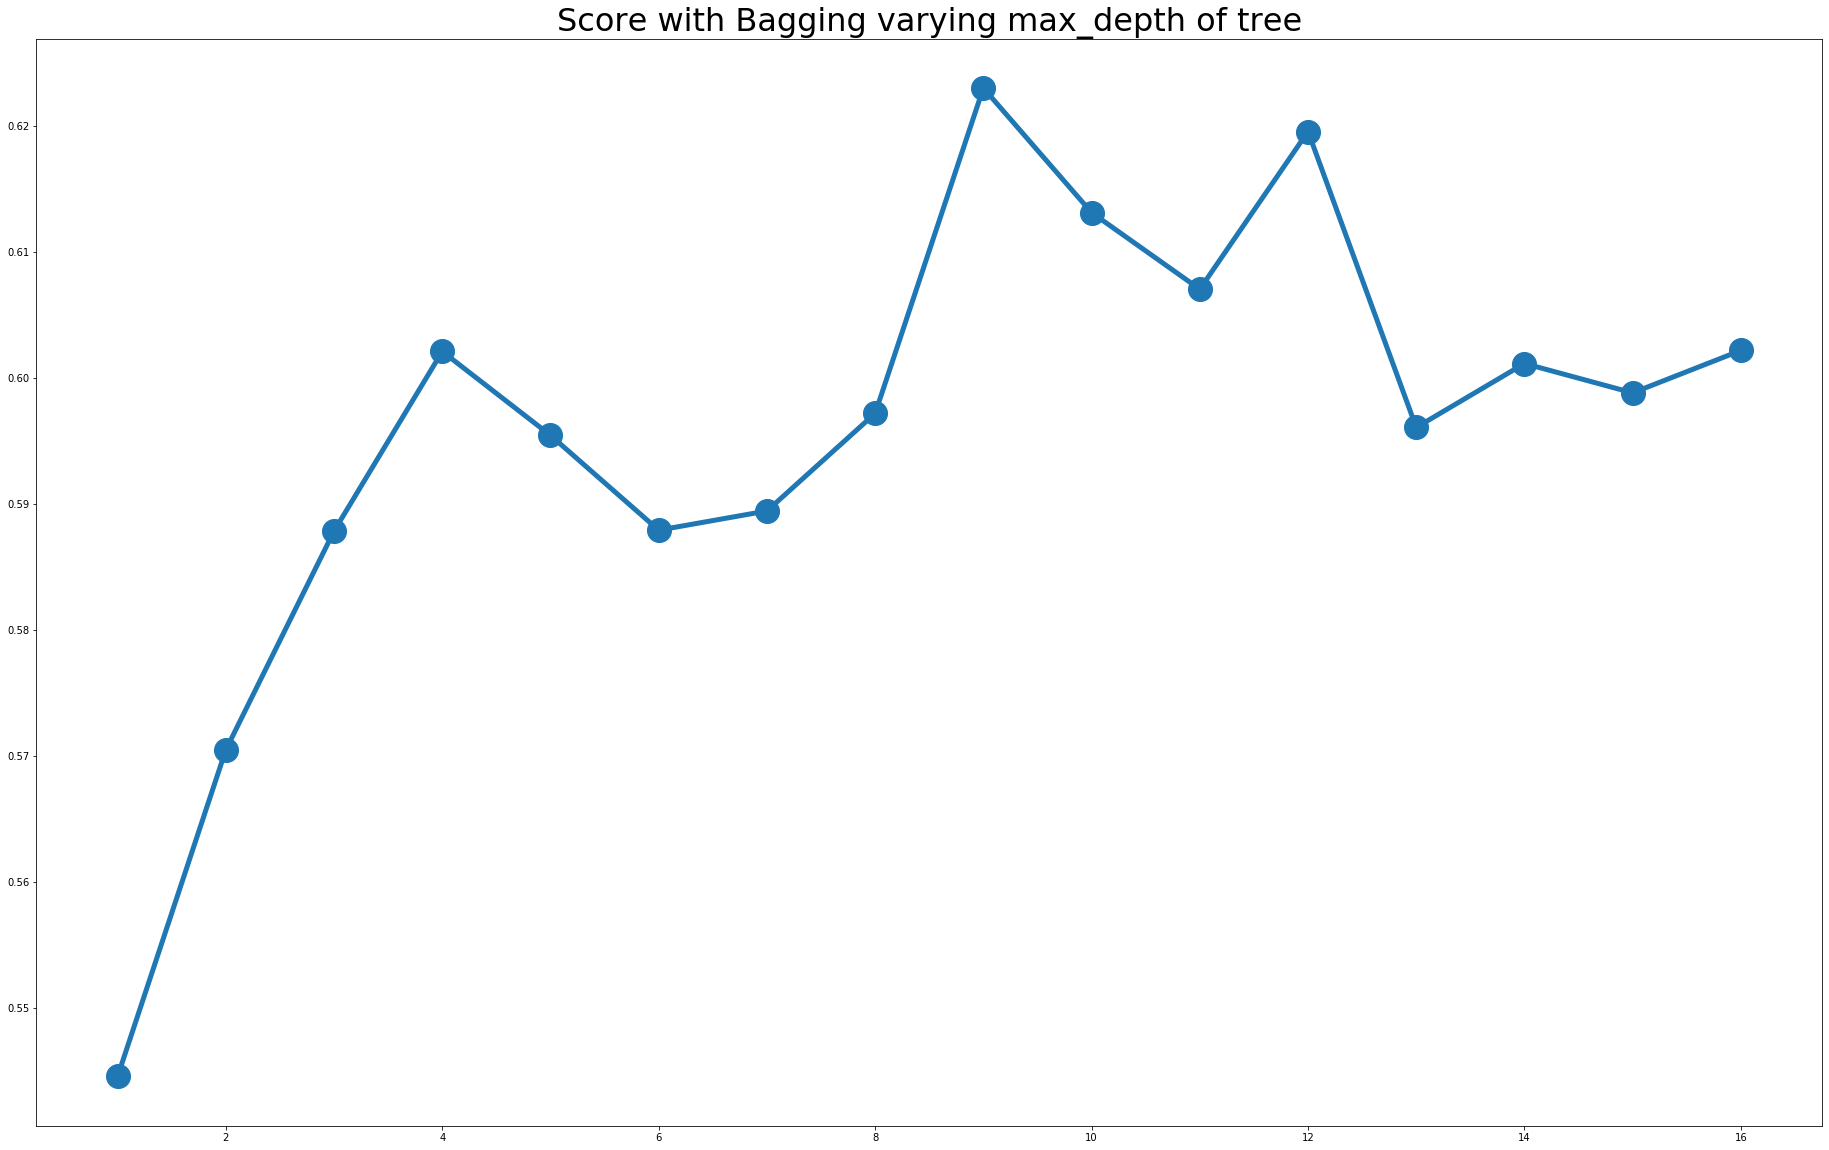

In [23]:
plt.figure(figsize=(32,20))
plt.title("Score with Bagging varying max_depth of tree", fontsize = 32)
plt.plot(parameter_values
         , scores_bagging
         , '-o', linewidth=5
         , markersize=24
        );


### Fit the tree after bagging and print summary
- store the parameter value giving the best score with `np.argmax(scores)`
- initialize an estimator as above, using the best parameter value computed above as maximum depth and `entropy` as criterion
- fit the estimator using the `train` part
- use the fitted estimator to predict using the test features
- compute the accuracy on the test and store it on a variable for the final summary
- print the accuracy on the test set and the best parameter value

In [24]:
top_par_bagging = parameter_values[np.argmax(scores_bagging)]
estimator_bagging = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy"
                                            , max_depth = top_par_bagging
                                            )
                                          , max_samples=0.5
                                          , max_features=0.5
                                         )
estimator_bagging.fit(X_train,y_train); # the semicolon at the end prevents the out[]
y_pred_bagging = estimator_bagging.predict(X_test)

accuracy_bagging = accuracy_score(y_pred_bagging, y_test)*100
print("The accuracy on test set tuned with bagging is {0:.1f}%".format(accuracy_bagging))
print("Obtained with max_depth = {}".format(top_par_bagging))

The accuracy on test set tuned with bagging is 61.5%
Obtained with max_depth = 9


### Final report
Print a summary of the four experiments

In [25]:
print("                                        Accuracy   Hyperparameter")
print("Simple HoldOut and full tree        :   {:.1f}%      {}".format(accuracy_ho, fitted_max_depth))
print("HoldOut and tuning on validation set:   {:.1f}%      {}".format(accuracy_hov, top_par_hov))
print("CrossValidation and tuning          :   {:.1f}%      {}".format(accuracy_cv, top_par_cv))
print("Ensemble Bagging and tuning         :   {:.1f}%      {}".format(accuracy_bagging, top_par_bagging))

                                        Accuracy   Hyperparameter
Simple HoldOut and full tree        :   58.8%      16
HoldOut and tuning on validation set:   56.0%      13
CrossValidation and tuning          :   59.2%      15
Ensemble Bagging and tuning         :   61.5%      9


In [26]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


### Suggested exercises
- try other datasets
- try to optimise the parameters "min_impurity_decrease" "min_samples_leaf" and "min_samples_split"